# Understanding Agentic RAG

## What is RAG?
RAG stands for **Retrieval-Augmented Generation**.  
It means an AI model doesn’t rely only on what it already knows internally.  
Instead, it does two things:
- **Retrieves** information from external sources (like documents, databases, or APIs).  
- **Augments** its answer with that retrieved information to give a more accurate response.  

---

## What is Agentic RAG?
Agentic RAG is an advanced version of RAG where the model behaves more like an **agent** that can plan and act in multiple steps.  

The process looks like this:
1. **Plan** → The model decides what information it needs.  
2. **Retrieve** → It searches for relevant information from external sources.  
3. **Reason** → It checks if the information is enough.  
4. **Loop** → If the information is missing, it refines the query and searches again.  
5. **Answer** → Finally, it generates a well-informed and complete response.  

---

## Analogy
- **Plain RAG**: Like asking a friend one question and they go to the library once, grab a book, and give you an answer.  
- **Agentic RAG**: Like asking a friend who is willing to make several trips to the library, check indexes, compare different sources, and then give you a much better, researched answer.  

---

## Key Takeaway
- **RAG** = Retrieve once, then answer.  
- **Agentic RAG** = Think, plan, retrieve multiple times, and then answer.  
- This makes Agentic RAG more powerful and reliable for complex tasks that need multiple steps of reasoning.  




![Agentic Rag Workflow](AGENTIC_RAG.png)



### Agentic Langgraph Workflow

<img src="AGENTIC_RAG_LANGGRAPH.png" alt="Uploaded Picture" width="300">


In [6]:
# !pip install faiss-cpu
# !pip install langgraph
# !pip install langchain
# !pip install langchain-core
# !pip install langchain-community'
# !pip install langchain-openai


In [7]:
# ------------------------------------------
# 🔑 Load Environment Variables and API Key
# ------------------------------------------

# 1. Import required libraries
import os
from dotenv import load_dotenv

# 2. Load variables from the .env file into environment
load_dotenv()

# 3. Set OpenAI API key from environment
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")





In [8]:
# ------------------------------------------------
# 📦 Import Required Libraries for LangChain Setup
# ------------------------------------------------

# 🔹 Load documents from the web
from langchain_community.document_loaders import WebBaseLoader

# 🔹 Vector database (FAISS) for storing embeddings
from langchain_community.vectorstores import FAISS

# 🔹 OpenAI embeddings (turn text into vectors)
from langchain_openai import OpenAIEmbeddings

# 🔹 Text splitter for breaking documents into chunks
from langchain_text_splitters import RecursiveCharacterTextSplitter



In [13]:
# ------------------------------------------------
# 🌐 Load Documents from Web Sources
# ------------------------------------------------

# 1. Define list of URLs to fetch content from
langgraph_urls = [
    "https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://medium.com/cyberark-engineering/building-production-ready-ai-agents-with-langgraph-a-real-life-use-case-7bda34c7f4e4"
]

# 2. Load documents from each URL using WebBaseLoader
docs=[WebBaseLoader(url).load() for url in langgraph_urls]
print(f"✅ Loaded {len(docs)} documents from {len(langgraph_urls)} URLs")


✅ Loaded 3 documents from 3 URLs


In [14]:
# ------------------------------------------------
# 🗂️ Flatten the List of Documents
# ------------------------------------------------

# docs currently looks like: [[doc1, doc2], [doc3], [doc4, doc5, ...]]
# We need a single flat list of documents

docs_list = [item for sublist in docs for item in sublist]

print(f"Total documents loaded: {len(docs_list)}")


Total documents loaded: 3


In [25]:
# ------------------------------------------------
# ✂️ Step 1: Split Documents into Chunks
# ------------------------------------------------
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Define how big each chunk should be (and overlap for context continuity)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,   # max characters per chunk
    chunk_overlap=100  # overlap between chunks for smoother context
)

# Apply splitter to our flattened list of documents
doc_splits = text_splitter.split_documents(docs_list)

print(f"Total chunks created: {len(doc_splits)}")

# ------------------------------------------------
# 🗄️ Step 2: Create Vector Database (FAISS)
# ------------------------------------------------

# Build FAISS vectorstore from document chunks
vectorstore_langgraph = FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)

# ------------------------------------------------
# 🔍 Step 3: Create a Retriever
# ------------------------------------------------
retriever = vectorstore_langgraph.as_retriever()

print("✅ Vectorstore and retriever are ready!")
                                                                                       # search_kwargs={"k": 3,"score_threshold": 0.7}

Total chunks created: 135
✅ Vectorstore and retriever are ready!


In [26]:
# ------------------------------------------------
# 🔍 Ask the retriever (tuned) and show readable results
# ------------------------------------------------


query = "In LangGraph, what is a workflow?"
results = retriever.invoke(query)  # returns List[Document]

def preview(text, n=500):
    text = (text or "").replace("\n", " ")
    return text[:n] + ("…" if len(text) > n else "")

for i, doc in enumerate(results, 1):
    meta = getattr(doc, "metadata", {}) or {}
    src = meta.get("source") or meta.get("url") or meta.get("Source") or "Unknown source"
    print(f"[{i}] Source: {src}")
    print(preview(doc.page_content))
    print("-" * 80)


[1] Source: https://jordan-mungujakisa.medium.com/creating-an-ai-blog-post-generator-with-langchain-a-step-by-step-guide-b96e896c89c0
concept of workflows. A workflow is basically a series of pre-determined steps that are carried out with the aim of achieving an end goal using AI. The workflow that impressed me the most was the SEO(Search engine optimization) Optimized Blog Generator workflow, which basically searches the web, picks the top 3 search results, analyses their structure, generates questions, blog title, blog outline and finally the final blog. And I thought this would be a great opportunity to use LangChain to
--------------------------------------------------------------------------------
[2] Source: https://python.langchain.com/docs/tutorials/
Refer to the how-to guides for more detail on using all LangChain components. Orchestration​ Get started using LangGraph to assemble LangChain components into full-featured applications.
--------------------------------------------

In [27]:
# ------------------------------------------------
# 🛠️ Step 1: Import Retriever Tool Builder
# ------------------------------------------------
from langchain.tools.retriever import create_retriever_tool

# ------------------------------------------------
# 🛠️ Step 2: Wrap Retriever as a Tool
# ------------------------------------------------
retriever_tool = create_retriever_tool(
    retriever=retriever,                         # the retriever we built from FAISS
    name="retriever_vector_from_db1",            # unique tool name (used by agents)
    description="Search and retrieve information about LangGraph articles"  
)

print("✅ Retriever tool created!")


✅ Retriever tool created!


### Langchain Blogs- Seperate Vector Store


In [28]:
# ------------------------------------------------
# 🌐 Load LangChain Documents from Web Sources
# ------------------------------------------------

# 1. Define list of URLs to fetch content from
langchain_urls = [
    "https://python.langchain.com/docs/tutorials/",
    "https://www.analyticsvidhya.com/blog/2025/07/langchain-fitness-coach/",
    "https://jordan-mungujakisa.medium.com/creating-an-ai-blog-post-generator-with-langchain-a-step-by-step-guide-b96e896c89c0"
]


# 2. Load documents from each URL using WebBaseLoader
docs=[WebBaseLoader(url).load() for url in langchain_urls]
print(f"✅ Loaded {len(docs)} documents from {len(langchain_urls)} URLs")


✅ Loaded 3 documents from 3 URLs


In [29]:
# ------------------------------------------------
# 🗂️ Flatten the List of Documents
# ------------------------------------------------

# docs currently looks like: [[doc1, doc2], [doc3], [doc4, doc5, ...]]
# We need a single flat list of documents

docs_list = [item for sublist in docs for item in sublist]

print(f"Total documents loaded: {len(docs_list)}")


Total documents loaded: 3


In [30]:

# ------------------------------------------------
# ✂️ Step 1: Split Documents into Chunks
# ------------------------------------------------
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,   # maximum characters per chunk
    chunk_overlap=100  # overlap between chunks (keeps context flow)
)

doc_splits = text_splitter.split_documents(docs_list)

print(f"✅ Created {len(doc_splits)} chunks from {len(docs_list)} documents")

# ------------------------------------------------
# 🗄️ Step 2: Build Vector Database (FAISS)
# ------------------------------------------------
vectorstore_langchain = FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)

print("✅ Vectorstore for LangChain created")

# ------------------------------------------------
# 🔍 Step 3: Create Retriever
# ------------------------------------------------
retriever_langchain = vectorstore_langchain.as_retriever()

print("✅ Retriever for LangChain is ready!")


✅ Created 135 chunks from 3 documents
✅ Vectorstore for LangChain created
✅ Retriever for LangChain is ready!


In [31]:
# ------------------------------------------------
# 🔍 Ask the retriever (tuned) and show readable results
# ------------------------------------------------


query = "what is langchain?"
results = retriever_langchain.invoke(query)  # returns List[Document]

def preview(text, n=500):
    text = (text or "").replace("\n", " ")
    return text[:n] + ("…" if len(text) > n else "")

for i, doc in enumerate(results, 1):
    meta = getattr(doc, "metadata", {}) or {}
    src = meta.get("source") or meta.get("url") or meta.get("Source") or "Unknown source"
    print(f"[{i}] Source: {src}")
    print(preview(doc.page_content))
    print("-" * 80)


[1] Source: https://www.analyticsvidhya.com/blog/2025/07/langchain-fitness-coach/
Use Cases for Langchain
--------------------------------------------------------------------------------
[2] Source: https://www.analyticsvidhya.com/blog/2025/07/langchain-fitness-coach/
Langchain enables you to do much more when building advanced AI applications by combining large language models (LLMs) with tools, data sources, and memory. Instead of invoking the LLM with a plain text prompt, you can create agents that invoke functions, query information, and manage conversations with state. For a fitness coach, Langchain allows you to combine LLM intelligence with custom logic – for example, create workout suggestions, track progress, and get health data – so you can be a
--------------------------------------------------------------------------------
[3] Source: https://python.langchain.com/docs/tutorials/
Tutorials | 🦜️🔗 LangChain
----------------------------------------------------------------------

In [32]:
# ------------------------------------------------
# 🛠️ Step 1: Import Retriever Tool Builder
# ------------------------------------------------
from langchain.tools.retriever import create_retriever_tool

# ------------------------------------------------
# 🛠️ Step 2: Wrap LangChain Retriever as a Tool
# ------------------------------------------------
retriever_tool_langchain = create_retriever_tool(
    retriever=retriever_langchain,                 # our FAISS retriever for LangChain docs
    name="retriever_vector_from_db2",              # unique name for this retriever tool
    description="Search and retrieve information about LangChain"  
)

print("✅ LangChain retriever tool created successfully!")


✅ LangChain retriever tool created successfully!


In [33]:
# ------------------------------------------------
# 🧰 Collect All Tools
# ------------------------------------------------

# Combine both retriever tools into one list
tools = [
    retriever_tool,            # LangGraph retriever
    retriever_tool_langchain   # LangChain retriever
]

print(f"✅ Tools ready: {len(tools)} retrievers available")
for t in tools:
    print(f"- {t.name}: {t.description}")


✅ Tools ready: 2 retrievers available
- retriever_vector_from_db1: Search and retrieve information about LangGraph articles
- retriever_vector_from_db2: Search and retrieve information about LangChain


### LangGraph Workflow

In [34]:
# ------------------------------------------------
# 🧩 Step 1: Import Dependencies
# ------------------------------------------------
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# ------------------------------------------------
# 🧩 Step 2: Define the Agent's State
# ------------------------------------------------
class AgentState(TypedDict):
    """
    Defines the structure of the agent's memory/state.
    
    - messages: A sequence of chat messages exchanged between user and agent.
    - Annotated[...] + add_messages: ensures that when state updates happen,
      new messages are appended instead of replacing the old ones.
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

print("✅ AgentState schema defined")


✅ AgentState schema defined


In [35]:
# ------------------------------------------------
# 🤖 Step 1: Import Chat Model
# ------------------------------------------------
from langchain_openai import ChatOpenAI

# ------------------------------------------------
# 🤖 Step 2: Initialize the LLM
# ------------------------------------------------
llm = ChatOpenAI(
    model="gpt-4.1-nano-2025-04-14",  # pick your model
    temperature=0.7,                   # controls randomness (0 = deterministic)
)

# ------------------------------------------------
# 🤖 Step 3: Quick Sanity Check
# ------------------------------------------------
response = llm.invoke("Hi")
print("✅ LLM Response:", response.content)


✅ LLM Response: Hello! How can I assist you today?


In [36]:
# ------------------------------------------------
# 🤖 Define the Agent Node Function
# ------------------------------------------------


def agent(state):
    """
    Agent node that invokes the LLM and decides whether to:
      - Use retriever tools (LangGraph / LangChain knowledge bases), or
      - Respond directly without tool use.

    Args:
        state (dict): The current agent state containing chat messages.

    Returns:
        dict: Updated state with the agent's response appended to messages.
    """
    print("--- CALL AGENT ---")
    
    # Extract current conversation
    messages = state["messages"]

    # Initialize the LLM
    model = ChatOpenAI(
        model="gpt-4.1-nano-2025-04-14",
        temperature=0.7
    )

    # Bind retriever tools so the model can decide when to use them
    model = model.bind_tools(tools)

    # Invoke the LLM with conversation history
    response = model.invoke(messages)

    # Return response appended as a list (LangGraph expects list appending)
    return {"messages": [response]}

print("✅ Agent node function defined")


✅ Agent node function defined


In [37]:
# ------------------------------------------------
# 📦 Imports for Agent Workflow
# ------------------------------------------------

# 🔹 Typing and schemas
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

# 🔹 LangChain core primitives
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# 🔹 Validation / structured outputs
from pydantic import BaseModel, Field


In [38]:
# ------------------------------------------------
# 🔗 Edge Function: Grade Retrieved Documents
# ------------------------------------------------
from typing import Literal
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.
    Returns:
        "generate" if docs are relevant,
        "rewrite" if docs are not relevant.
    """

    print("--- CHECK RELEVANCE ---")

    # ------------------------------------------------
    # 🧩 Step 1: Define Output Schema
    # ------------------------------------------------
    class Grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score: 'yes' or 'no'")

    # ------------------------------------------------
    # 🧩 Step 2: Initialize LLM with Structured Output
    # ------------------------------------------------
    model = ChatOpenAI(model="gpt-4.1-nano-2025-04-14", temperature=0)
    llm_with_tool = model.with_structured_output(Grade)

    # ------------------------------------------------
    # 🧩 Step 3: Define Relevance Prompt
    # ------------------------------------------------
    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )


    # Build the chain
    chain = prompt | llm_with_tool

    # ------------------------------------------------
    # 🧩 Step 4: Extract Question & Docs from State
    # ------------------------------------------------
    messages = state["messages"]
    last_message = messages[-1]         # retrieved docs (or agent response)
    question = messages[0].content      # original user query
    docs = last_message.content         # doc contents to grade

    # ------------------------------------------------
    # 🧩 Step 5: Run the Grader
    # ------------------------------------------------
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score.lower()

    # ------------------------------------------------
    # 🧩 Step 6: Decision
    # ------------------------------------------------
    if score == "yes":
        print("--- DECISION: DOCS RELEVANT ---")
        return "generate"
    else:
        print("--- DECISION: DOCS NOT RELEVANT ---")
        return "rewrite"


In [39]:
# ------------------------------------------------
# 📝 Node: Generate Final Answer
# ------------------------------------------------
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

def generate(state):
    """
    Generate a final answer from retrieved documents and user question.

    Args:
        state (dict): Current state containing conversation messages.

    Returns:
        dict: Updated state with the generated answer appended.
    """
    print("--- GENERATE ---")

    # ------------------------------------------------
    # 🧩 Step 1: Extract Question & Retrieved Docs
    # ------------------------------------------------
    messages = state["messages"]
    question = messages[0].content        # user question
    last_message = messages[-1]           # retrieved documents or agent response
    docs = last_message.content

    # ------------------------------------------------
    # 🧩 Step 2: Load Prompt Template
    # ------------------------------------------------
    # rlm/rag-prompt is a community template for RAG-style answers
    prompt = hub.pull("rlm/rag-prompt")

    # ------------------------------------------------
    # 🧩 Step 3: Initialize LLM
    # ------------------------------------------------
    llm = ChatOpenAI(model="gpt-4.1-nano-2025-04-14", temperature=0)

    # ------------------------------------------------
    # 🧩 Step 4: Define Chain (Prompt → LLM → Parser)
    # ------------------------------------------------
    rag_chain = prompt | llm | StrOutputParser()

    # ------------------------------------------------
    # 🧩 Step 5: Run Chain
    # ------------------------------------------------
    response = rag_chain.invoke({
        "context": docs,
        "question": question
    })

    # LangGraph expects list so we wrap response
    return {"messages": [response]}


In [40]:
# ------------------------------------------------
# 🔄 Node: Rewrite Query
# ------------------------------------------------
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

def rewrite(state):
    """
    Reformulate the user query into a better, clearer version
    if retrieved documents were not relevant.

    Args:
        state (dict): Current state containing conversation messages.

    Returns:
        dict: Updated state with the rewritten question appended.
    """
    print("--- TRANSFORM QUERY ---")

    # ------------------------------------------------
    # 🧩 Step 1: Extract the Original Question
    # ------------------------------------------------
    messages = state["messages"]
    question = messages[0].content

    # ------------------------------------------------
    # 🧩 Step 2: Build Rewriting Prompt
    # ------------------------------------------------
    msg = [
        HumanMessage(
            content=f"""
            Look at the input and reason about the underlying semantic intent.  
            Here is the initial question:
            -------------------
            {question}
            -------------------
            Please rewrite this into a clearer, improved question.
            """
        )
    ]

    # ------------------------------------------------
    # 🧩 Step 3: Call LLM to Rewrite
    # ------------------------------------------------
    model = ChatOpenAI(model="gpt-4.1-nano-2025-04-14", temperature=0.3)
    response = model.invoke(msg)

    # ------------------------------------------------
    # 🧩 Step 4: Return Updated State
    # ------------------------------------------------
    return {"messages": [response]}


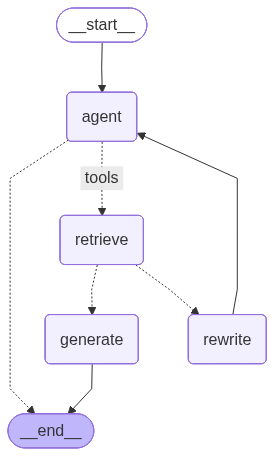

✅ Workflow compiled and visualized.


In [41]:
# ------------------------------------------------
# 🕸️ Build the LangGraph Workflow (Nodes + Edges)
# ------------------------------------------------
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# ------------------------------------------------
# 1) Initialize the stateful workflow with our AgentState
# ------------------------------------------------
workflow = StateGraph(AgentState)

# ------------------------------------------------
# 2) Register Nodes
#    - "agent": decides to use tools or answer directly
#    - "retrieve": executes retriever tools (LangGraph + LangChain)
#    - "rewrite": improves the user query if retrieval was irrelevant
#    - "generate": synthesizes final answer from retrieved docs
# ------------------------------------------------
workflow.add_node("agent", agent)

# Use the tools list you previously created: tools = [retriever_tool, retriever_tool_langchain]
retrieve_node = ToolNode(tools)
workflow.add_node("retrieve", retrieve_node)

workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

# ------------------------------------------------
# 3) Entry Edge: START -> agent
# ------------------------------------------------
workflow.add_edge(START, "agent")

# ------------------------------------------------
# 4) Conditional from agent:
#    - If model decides to use tools -> go to "retrieve"
#    - If model ends (no tool)      -> END
# ------------------------------------------------
workflow.add_conditional_edges(
    "agent",
    tools_condition,                 # inspects the agent output for tool usage
    {
        "tools": "retrieve",         # when tools are requested
        END: END,                    # when agent chooses to finish
    },
)

# ------------------------------------------------
# 5) Conditional after retrieve:
#    - grade_documents returns "generate" or "rewrite"
# ------------------------------------------------
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,                 # returns "generate" or "rewrite"
)

# ------------------------------------------------
# 6) Final Edges
# ------------------------------------------------
workflow.add_edge("generate", END)   # after generating, finish
workflow.add_edge("rewrite", "agent")# after rewriting, try agent again

# ------------------------------------------------
# 7) Compile the graph and visualize
# ------------------------------------------------
graph = workflow.compile()

# Visualize the compiled graph (Mermaid PNG)
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
print("✅ Workflow compiled and visualized.")


In [42]:
# ------------------------------------------------
# ▶️ Run the Workflow
# ------------------------------------------------
from langchain_core.messages import HumanMessage

# Wrap the input in a HumanMessage
input_state = {
    "messages": [HumanMessage(content="What is LangGraph?")]
}

# Invoke the workflow
result = graph.invoke(input_state)

# ------------------------------------------------
# 📌 Show Final Answer
# ------------------------------------------------
print("✅ Graph execution completed\n")
final_answer = result["messages"][-1].content
print("💡 Answer:\n", final_answer)





--- CALL AGENT ---
--- CHECK RELEVANCE ---
--- DECISION: DOCS RELEVANT ---
--- GENERATE ---
✅ Graph execution completed

💡 Answer:
 LangGraph is a tool within the LangChain ecosystem used to assemble LangChain components into full-featured applications. It facilitates orchestration of these components to build complex AI applications. It is part of the broader set of tools and guides available for developing with LangChain.


In [43]:
# ------------------------------------------------
# ▶️ Run Workflow with LangChain Question
# ------------------------------------------------


# Wrap the input as a HumanMessage inside a list
input_state = {
    "messages": [HumanMessage(content="What is LangChain?")]
}

# Invoke the workflow
result = graph.invoke(input_state)

# ------------------------------------------------
# 📌 Show Only Final Answer
# ------------------------------------------------
print("✅ Graph execution completed\n")
print(result["messages"][-1].content)


--- CALL AGENT ---
--- CHECK RELEVANCE ---
--- DECISION: DOCS RELEVANT ---
--- GENERATE ---
✅ Graph execution completed

LangChain is a framework that enables the development of advanced AI applications by integrating large language models (LLMs) with tools, data sources, and memory. It allows creating agents that can invoke functions, query information, and manage conversations with state. Essentially, it helps build more interactive and intelligent AI systems.


In [44]:


# Input query
input_state = {
    "messages": [HumanMessage(content="What is Machine learning?")]
}

# Run the workflow
result = graph.invoke(input_state)

# ✅ Print only the final answer content
print(result["messages"][-1].content)


--- CALL AGENT ---
--- CHECK RELEVANCE ---
--- DECISION: DOCS RELEVANT ---
--- GENERATE ---
Machine learning is a subset of artificial intelligence that involves developing algorithms and models that enable computers to learn from and make decisions based on data. It encompasses techniques like supervised, unsupervised, and reinforcement learning to identify patterns and improve performance over time. It serves as the foundation for many advanced AI applications, including generative AI and large language models.
